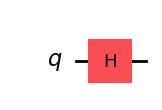

In [8]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp

# The following code will work for any other initial single-qubit state and observable
original_circuit = QuantumCircuit(1)
original_circuit.h(0)

H = SparsePauliOp(["X", "Z"], [2, -1])

aux_circuits = []
for pauli in H.paulis:
    aux_circ = original_circuit.copy()
    aux_circ.barrier()
    if str(pauli) == "X":
        aux_circ.h(0)
    elif str(pauli) == "Y":
        aux_circ.sdg(0)
        aux_circ.h(0)
    else:
        aux_circ.id(0)
    aux_circ.measure_all()
    aux_circuits.append(aux_circ)

original_circuit.draw("mpl")

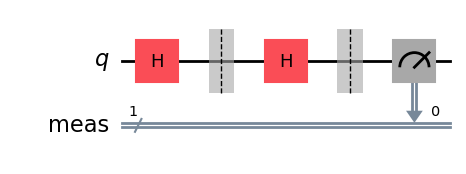

In [9]:
# Auxiliary circuit for X
aux_circuits[0].draw('mpl')

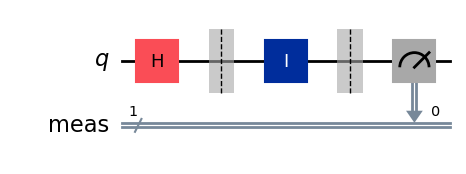

In [10]:
# Auxiliary circuit for Z
aux_circuits[1].draw('mpl')

In [11]:
from qiskit.primitives import StatevectorSampler, StatevectorEstimator
from qiskit.result import QuasiDistribution
from qiskit.circuit.library import IGate, ZGate, XGate, YGate
import numpy as np


## SAMPLER
shots = 10000
sampler = StatevectorSampler()
job = sampler.run(aux_circuits, shots = shots)
data_pub = job.result()[1].data
bitstrings = data_pub.meas.get_bitstrings()
counts = data_pub.meas.get_counts()
quasi_dist = QuasiDistribution({outcome: freq / shots for outcome, freq in counts.items()})

expvals = []
for pauli in H.paulis:
    val = 0
    
    if str(pauli) == "I":
        Lambda = IGate().to_matrix().real
    
    if str(pauli) == "X":
        Lambda = XGate().to_matrix().real
        val += Lambda[0][1] * quasi_dist.get(1)
        val += Lambda[1][0] * quasi_dist.get(0)
    
    if str(pauli) == "Y":
        Lambda = XGate().to_matrix().real
        val += Lambda[0][1] * 1.j * quasi_dist.get(1)
        val += Lambda[1][0] * -1.j * quasi_dist.get(0)

    if str(pauli) == "Z":
        Lambda = ZGate().to_matrix().real
        val += Lambda[0][0] * quasi_dist.get(0)
        val += Lambda[1][1] * quasi_dist.get(1)
    
    expvals.append(val)

print("Sampler results:")
for (pauli, expval) in zip(H.paulis, expvals):
    print(f"  >> Expected value of {str(pauli)}: {expval:.5f}")

total_expval = np.sum(H.coeffs * expvals).real
print(f"  >> Total expected value: {total_expval:.5f}")

## ESTIMATOR
observables = [
    *H.paulis,H
]  # Note: run for individual Paulis as well as full observable H

estimator = StatevectorEstimator()
job = estimator.run([(original_circuit, observables)])
estimator_expvals = job.result()[0].data.evs

print("Estimator results:")
for (obs, expval) in zip(observables, estimator_expvals):
    if obs is not H:
        print(f"  >> Expected value of {str(obs)}: {expval:.5f}")
    else:
        print(f"  >> Total expected value: {expval:.5f}")

Sampler results:
  >> Expected value of X: 1.00000
  >> Expected value of Z: 0.00560
  >> Total expected value: 1.99440
Estimator results:
  >> Expected value of X: 1.00000
  >> Expected value of Z: 0.00000
  >> Total expected value: 2.00000


In [12]:
def cost_func_vqe(params, circuit, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (circuit, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs

#    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

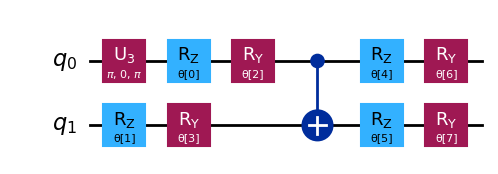

In [13]:
from qiskit.circuit.library import TwoLocal

observable = SparsePauliOp.from_list([("XX", 1), ("YY", -3)])

reference_circuit = QuantumCircuit(2)
reference_circuit.x(0)

variational_form = TwoLocal(
    2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)
ansatz = reference_circuit.compose(variational_form)

theta_list = (2 * np.pi * np.random.rand(1, 8)).tolist()
#ansatz.assign_parameters(theta_list)
#print(ansatz.num_parameters)
ansatz.decompose().draw('mpl')

In [14]:
#Estimated usage: < 1 min. Benchmarked at 7 seconds on ibm_osaka, 5-23-24
#Load necessary packages:

from qiskit_ibm_runtime import QiskitRuntimeService, Session, EstimatorV2 as Estimator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

#Select the least busy backend:

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(
    operational=True, min_num_qubits=ansatz.num_qubits, simulator=False
)

#Use a pass manager to transpile the circuit and observable for the specific backend being used:

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_ansatz = pm.run(ansatz)
isa_observable = observable.apply_layout(layout = isa_ansatz.layout)

#Open a Runtime session:

session = Session(backend=backend)

# Use estimator to get the expected values corresponding to the ansatz

estimator = Estimator(session=session)
cost = cost_func_vqe(theta_list, isa_ansatz, isa_observable, estimator)

# Close session after done
session.close()
print(cost)

AccountNotFoundError: 'Unable to find account.'

In [ ]:
%pip install pydantic -U

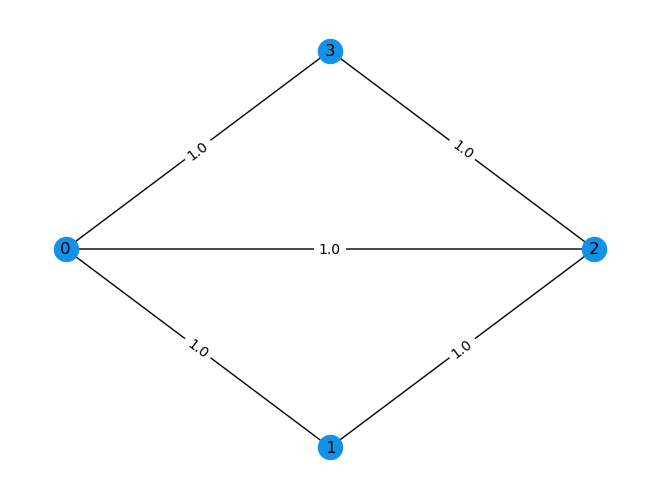

In [15]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw

n = 4
G = rx.PyGraph()
G.add_nodes_from(range(n))
# The edge syntax is (start, end, weight)
edges = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)]
G.add_edges_from(edges)

mpl_draw(G, pos=rx.shell_layout(G), with_labels=True, edge_labels=str, node_color="#1192E8")

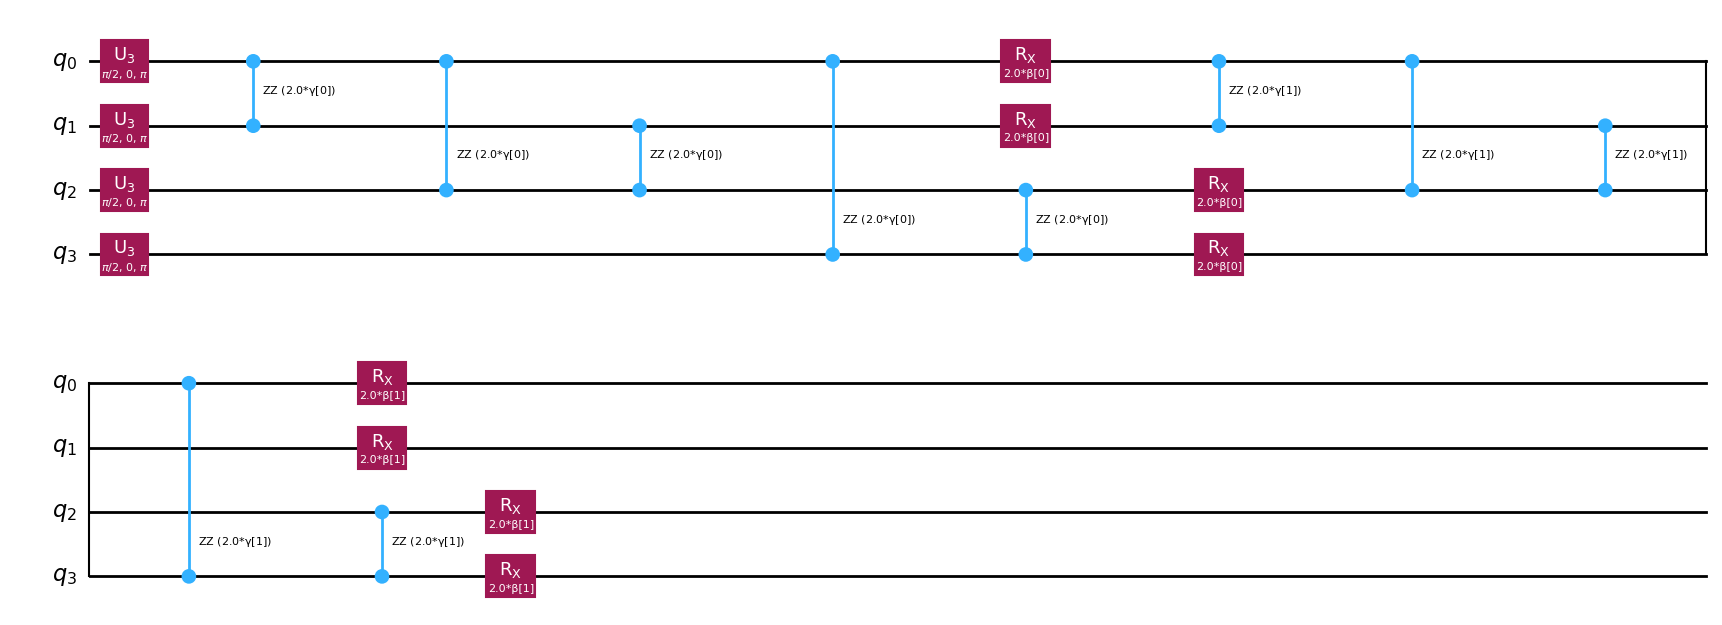

In [16]:
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp

hamiltonian = SparsePauliOp.from_list([
    ("IIZZ", 1), ("IZIZ", 1), ("IZZI", 1), ("ZIIZ", 1), ("ZZII", 1)
])


ansatz = QAOAAnsatz(hamiltonian, reps=2)
# Draw
ansatz.decompose(reps=3).draw("mpl")

In [17]:
# Sum the weights, and divide by 2

offset = - sum(edge[2] for edge in edges) / 2
print(f"""Offset: {offset}""")

Offset: -2.5


In [18]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs
#    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

In [19]:
import numpy as np

x0 = 2 * np.pi * np.random.rand(ansatz.num_parameters)

estimator = StatevectorEstimator()
cost = cost_func_vqe(x0, ansatz, hamiltonian, estimator)
print(cost)

-0.2367773796796211


In [20]:
#Estimated usage: < 1 min, benchmarked at 6 seconds on ibm_osaka, 5-23-24
#Load some necessary packages:

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator

#Select the least busy backend:

backend = service.least_busy(
    operational=True, min_num_qubits=ansatz.num_qubits, simulator=False
)

#Use a pass manager to transpile the circuit and observable for the specific backend being used:

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_ansatz = pm.run(ansatz)
isa_hamiltonian = hamiltonian.apply_layout(layout = isa_ansatz.layout)

#Open a Runtime session:

session = Session(backend=backend)

# Use estimator to get the expected values corresponding to each ansatz
estimator = Estimator(session=session)

cost = cost_func_vqe(x0, isa_ansatz, isa_hamiltonian, estimator)

# Close session after done
session.close()
print(cost)

NameError: name 'service' is not defined